In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from sklearn import feature_extraction, model_selection, naive_bayes, metrics, svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support as score
%matplotlib inline

In [2]:
df = pd.read_csv("sms_spam.csv", encoding='latin-1')

In [3]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
df = df.drop('Unnamed: 2', 1)
df = df.drop('Unnamed: 3', 1)
df = df.drop('Unnamed: 4', 1)

In [5]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
df = df.rename(columns = {'v1':'label','v2':'message'})

In [7]:
df.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

In [8]:
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


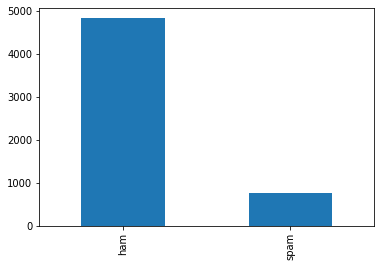

In [9]:
no_Class=pd.value_counts(df["label"], sort= True)
no_Class.plot(kind = 'bar')
plt.show();

In [10]:
ft = feature_extraction.text.CountVectorizer(stop_words = 'english')
X = ft.fit_transform(df["message"])
np.shape(X)

(5572, 8404)

## Naive Bayes

In [11]:
# spam= 1 || not spam= 0

df["label"]=df["label"].map({'spam':1,'ham':0})
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, df['label'], test_size=0.70, random_state=42)

In [12]:
l_alpha = np.arange(1/100000, 20, 0.11)
score_train = np.zeros(len(l_alpha))
score_test = np.zeros(len(l_alpha))
recall_test = np.zeros(len(l_alpha))
precision_test= np.zeros(len(l_alpha))
count = 0
for alpha in l_alpha:
    bayes = naive_bayes.MultinomialNB(alpha=alpha)
    bayes.fit(X_train, y_train)
    score_train[count] = bayes.score(X_train, y_train)
    score_test[count]= bayes.score(X_test, y_test)
    recall_test[count] = metrics.recall_score(y_test, bayes.predict(X_test))
    precision_test[count] = metrics.precision_score(y_test, bayes.predict(X_test))
    count = count + 1 

In [13]:
mat = np.matrix(np.c_[l_alpha, score_train, score_test, recall_test, precision_test])
model = pd.DataFrame(data = mat, columns = 
             ['alpha', 'Train Accuracy', 'Test Accuracy', 'Test Recall', 'Test Precision'])
model.head(n=10)


,alpha,Train Accuracy,Test Accuracy,Test Recall,Test Precision
0,0.00001,0.998803,0.961805,0.913793,0.820998
1,0.11001,0.998803,0.966163,0.946360,0.826087
2,0.22001,0.999402,0.967444,0.938697,0.837607
3,0.33001,0.999402,0.968726,0.938697,0.844828
4,0.44001,0.999402,0.971546,0.929119,0.867621
5,0.55001,0.998803,0.976160,0.925287,0.899441
6,0.66001,0.998803,0.976160,0.919540,0.903955
7,0.77001,0.997606,0.977698,0.917625,0.915870
8,0.88001,0.997606,0.977954,0.909962,0.924125
9,0.99001,0.997606,0.978980,0.902299,0.938247


In [14]:
index = model['Test Precision'].idxmax()
model.iloc[index, :]

alpha             10.670010
Train Accuracy     0.977259
Test Accuracy      0.962574
Test Recall        0.720307
Test Precision     1.000000
Name: 97, dtype: float64

## Random Forest Method

In [15]:
rf = RandomForestClassifier(n_estimators=100,max_depth=None,n_jobs=-1)
rf_model = rf.fit(X_train,y_train)

In [16]:
prediction = rf_model.predict(X_test)
precision,recall,fscore,support =score(y_test,prediction,pos_label=1, average ='binary')

In [17]:
print('Precision: {} | Recall: {} | Fscore: {} | Accuracy: {}'.format(round(precision,3),round(recall,3),round(fscore,3),round((prediction==y_test).sum()/len(y_test),3)))

Precision: 0.995 | Recall: 0.734 | Fscore: 0.845 | Accuracy: 0.964


## NLP using Tensorflow

In [18]:
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.layers import Embedding, LSTM, Dropout, Dense
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences

In [19]:
vocab_size = 400
oov_tok = "<OOV>"
max_length = 300
embedding_dim = 16
encode = ({'ham': 0, 'spam': 1} )

df = df.replace(encode)

In [20]:
X = df['message']
Y = df['label']
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X)

X = tokenizer.texts_to_sequences(X)

In [21]:
X = np.array(X)
y = np.array(Y)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [22]:
X = pad_sequences(X, maxlen=max_length)

In [23]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(25, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 16)           6400      
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 25)                425       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 26        
Total params: 6,851
Trainable params: 6,851
Non-trainable params: 0
_________________________________________________________________


In [24]:
epochs = 40
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.20, random_state=128)
history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test,y_test), verbose=2)

Epoch 1/40
140/140 - 2s - loss: 0.5333 - accuracy: 0.8582 - val_loss: 0.3803 - val_accuracy: 0.8735
Epoch 2/40
140/140 - 0s - loss: 0.3860 - accuracy: 0.8640 - val_loss: 0.3638 - val_accuracy: 0.8735
Epoch 3/40
140/140 - 0s - loss: 0.3777 - accuracy: 0.8640 - val_loss: 0.3551 - val_accuracy: 0.8735
Epoch 4/40
140/140 - 0s - loss: 0.3669 - accuracy: 0.8640 - val_loss: 0.3422 - val_accuracy: 0.8735
Epoch 5/40
140/140 - 0s - loss: 0.3496 - accuracy: 0.8640 - val_loss: 0.3208 - val_accuracy: 0.8735
Epoch 6/40
140/140 - 0s - loss: 0.3197 - accuracy: 0.8640 - val_loss: 0.2843 - val_accuracy: 0.8735
Epoch 7/40
140/140 - 0s - loss: 0.2696 - accuracy: 0.8640 - val_loss: 0.2291 - val_accuracy: 0.8735
Epoch 8/40
140/140 - 0s - loss: 0.2195 - accuracy: 0.8640 - val_loss: 0.1897 - val_accuracy: 0.8735
Epoch 9/40
140/140 - 0s - loss: 0.1917 - accuracy: 0.8934 - val_loss: 0.1706 - val_accuracy: 0.9435
Epoch 10/40
140/140 - 0s - loss: 0.1764 - accuracy: 0.9414 - val_loss: 0.1596 - val_accuracy: 0.9543

In [25]:
result = model.evaluate(X_test, y_test)
loss = result[0]
accuracy = result[1]


print(f"The Accuracy of the NLP Model is : {accuracy*100:.2f}%")

35/35 [==============================] - 0s 2ms/step - loss: 0.0680 - accuracy: 0.9857
The Accuracy of the NLP Model is : 98.57%


In [26]:
from keras.preprocessing import sequence
def get_prediction(sms):
    sms = tokenizer.texts_to_sequences(sms)
    sms = sequence.pad_sequences(sms, maxlen=max_length)
    pred = model.predict(sms)
    if(pred[0] > 0.5):
        print("SPAM")
    else:
        print('NOT SPAM')

In [27]:
text=["Call customer care you have won a cash prize!"]

get_prediction(text)

SPAM


In [28]:
text=["Please meet me tomorrow at 8"]

get_prediction(text)

NOT SPAM
